<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import matplotlib.pyplot as plt
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
# full bc
fbcs = [
  list("GGAGAAGA"),
  list("CCACAATG"),
  list("CCAACCGG"),
  list("CGAAGCCC"),
  list("TCAGTCGA"),
  list("GACCAGCC"),
  list("CTCAAGGT"),
  list("CGCCGCAA"),
  list("ACCAGCCG"),
]
# trim right
rbcs = [
  list("GGAGAAG"),
  list("CCACAAT"),
  list("CCAACCG"),
  list("CGAAGCC"),
  list("TCAGTCG"),
  list("GACCAGC"),
  list("CTCAAGG"),
  list("CGCCGCA"),
  list("ACCAGCC"),
]

# trim left
lbcs = [
  list("GAGAAGA"),
  list("CACAATG"),
  list("CAACCGG"),
  list("GAAGCCC"),
  list("CAGTCGA"),
  list("ACCAGCC"),
  list("TCAAGGT"),
  list("GCCGCAA"),
  list("CCAGCCG"),
]

bcs_names = [
"BC1",
"BC2",
"BC13",
"BC25",
"BC37",
"BC49",
"BC50",
"BC73",
"BC74",
]
bcs_list =[
"GGAGAAGA",
"CCACAATG",
"CCAACCGG",
"CGAAGCCC",
"TCAGTCGA",
"GACCAGCC",
"CTCAAGGT",
"CGCCGCAA",
"ACCAGCCG",
]
bcs = fbcs

# Check for shared kmer sequences in the forward and reverse strand

In [86]:
def gen_kmers(s, k):
  L = len(s)
  return [s[i:i+k] for i in range(L-k+1)]
gen_kmers("sina" ,3)

['sin', 'ina']

In [85]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
def rev_c(seq):
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases
rev_c("ATC")

'GAT'

In [87]:
from collections import defaultdict
def check_kmers(bcs, bcs_names, k=None):
  length = min([len(i) for i in bcs])
  if not k:
    k = length if length % 2 else length - 1
    print(f"Optimal kmer length: {k}")

  d = defaultdict(list)
  for bc, bc_name in zip(bcs, bcs_names):
    # forward
    kmers = gen_kmers(bc, k)
    for kmer in kmers:
      d["".join(kmer)].append(bc_name)
    
    # reverse complement
    kmers = gen_kmers(rev_c(bc), k)
    for kmer in kmers:
      d["".join(kmer)].append(bc_name + "_rc")
  return d

In [88]:
check_kmers(bcs_list, bcs_names)

Optimal kmer length: 7


defaultdict(list,
            {'ACCAGCC': ['BC49', 'BC74'],
             'ACCTTGA': ['BC50_rc'],
             'ATTGTGG': ['BC2_rc'],
             'CAACCGG': ['BC13'],
             'CACAATG': ['BC2'],
             'CAGTCGA': ['BC37'],
             'CATTGTG': ['BC2_rc'],
             'CCAACCG': ['BC13'],
             'CCACAAT': ['BC2'],
             'CCAGCCG': ['BC74'],
             'CCGGTTG': ['BC13_rc'],
             'CCTTGAG': ['BC50_rc'],
             'CGAAGCC': ['BC25'],
             'CGACTGA': ['BC37_rc'],
             'CGCCGCA': ['BC73'],
             'CGGCTGG': ['BC74_rc'],
             'CGGTTGG': ['BC13_rc'],
             'CTCAAGG': ['BC50'],
             'CTTCTCC': ['BC1_rc'],
             'GAAGCCC': ['BC25'],
             'GACCAGC': ['BC49'],
             'GAGAAGA': ['BC1'],
             'GCCGCAA': ['BC73'],
             'GCTGGTC': ['BC49_rc'],
             'GGAGAAG': ['BC1'],
             'GGCTGGT': ['BC49_rc', 'BC74_rc'],
             'GGCTTCG': ['BC25_rc'],
             'GG

We see that BC49 and BC74 share kmers.
```
'ACCAGCC': ['BC49', 'BC74'],
'GGCTGGT': ['BC49_rc', 'BC74_rc'],
```






# Simulate barcodes with errors

In [3]:
# each row is a feature barcode, each column is a nucleotide
bcs_mat = np.array(bcs)

In [106]:
err = 0.05
N = 100_000
bc_len = 8
n_bcs = len(bcs)
labels = np.arange(n_bcs)
np.random.seed(0)

In [173]:
# function, given a barcode, N, and error, return a list of mutants
def alt(barcode):
  # for each position the set of nucleotides that are not the given on
  d = set(["A", "T", "G", "C"])
  alt = [sorted(list(d.symmetric_difference(i))) for i in barcode]
  return alt

def mutate(barcode, N, err):
  barcode = list(barcode)
  bc_len = len(barcode)
  mutate_mask = np.random.rand(N,bc_len)<err

  # for each barcode for each base, the other possible nucleotide choices
  replace_opt = np.array(alt(barcode))

  # pick which of the 3 alternative nucleotides to change to
  replace_idx = np.random.choice(3, size=(N, bc_len))

  # select a single column for each row in replace_opt given by replace_idx 
  # do this for all N mutants, for each num_fb
  replace = np.array([replace_opt[np.arange(bc_len), i] for i in replace_idx]) 

  bc_mat = np.tile(barcode, (N, 1))

  # replace the nucleotides where mutate_mask is true
  bc_mat[mutate_mask] = replace[mutate_mask]
  ham = mutate_mask.sum(1)
  return (bc_mat, ham)

In [178]:
mutants = []
dist = []
for bc in bcs:
  m, d = mutate(bc, N, err)
  mutants.append(m)
  dist.append(d)

In [179]:
dist = np.concatenate(dist, 0)
mutants = np.concatenate(mutants, 0)
mutant_origin = np.repeat(labels, N)

In [181]:
total_dists = Counter(dist)

# Perform correction

In [183]:
from collections import Counter
def distances(mutants, bcs_mat):
  # for each mutant, determine the set of hamming distances
  ham = []
  for idx, m in enumerate(mutants):    
    d = []
    for tidx, t in enumerate(bcs_mat):
      d.append((t!=m).sum())
    ham.append(d)

  ham = np.array(ham)
  return ham

In [184]:
ham = distances(mutants, bcs_mat)

In [185]:
ham

array([[1, 5, 5, ..., 5, 5, 7],
       [0, 4, 5, ..., 5, 5, 7],
       [0, 4, 5, ..., 5, 5, 7],
       ...,
       [7, 5, 3, ..., 5, 4, 0],
       [7, 5, 3, ..., 5, 4, 0],
       [7, 5, 4, ..., 6, 4, 1]])

In [186]:
%%time
# [ min , max)
# We want the maximum hamming after which it is ambiguous
assign = []
for h in ham:
  c = Counter(h)

  du = np.array([*c.keys()])
  du_argsort = np.argsort(du)

  one_idx, two_idx, *_ = du_argsort
  one_ham, two_ham = du[one_idx], du[two_idx]

  one_mul, two_mul = c[one_ham], c[two_ham]
  if one_mul == 1:
    min_ham = one_ham
    max_ham = two_ham 
    target = np.where(h == one_ham)[0][0]
  elif one_mul > 1:
    min_ham = one_ham - 1
    max_ham = one_ham
    target = -1

  assign.append([target, min_ham,  max_ham])
assign = np.array(assign)

CPU times: user 24 s, sys: 2.51 s, total: 26.5 s
Wall time: 23.6 s


In [187]:
assign

array([[0, 1, 3],
       [0, 0, 3],
       [0, 0, 3],
       ...,
       [8, 0, 3],
       [8, 0, 3],
       [8, 1, 4]])

In [188]:
# assigned correctly, assigned incorrectly, ambiguous

In [189]:
# barcodes that are impossible to assign for any hamming distance
ambiguous = np.equal(assign[:,0], -1)
print(f"Ambiguous barcodes: {ambiguous.sum():,.0f} [{ambiguous.sum()/(N*n_bcs):,.2f}%]")

Ambiguous barcodes: 4,765 [0.01%]


In [190]:
# barcodes that are given the correct assignment
correct = np.equal(assign[:,0], mutant_origin)
print(f"Correct barcodes: {correct.sum():,.0f} [{correct.sum()/(N*n_bcs):,.2f}%]")

Correct barcodes: 894,299 [0.99%]


for each error, for each hamming distance correction, plot the percent of barcodes that can be correctly assigned

so its the number of barcodes that can be assingned with min ham distance X and max hamm distance Y

for example, a barcode with a min hamming distance of 1 and a max of 2 would mean that it will become ambiguous once you go to 2 or more hamming distance but not at 1

In [191]:
mask = np.logical_and(correct, ~ambiguous)
data = Counter(np.array(assign)[:,1][mask])

In [192]:
data.items()

dict_items([(1, 231354), (0, 628586), (2, 32707), (3, 1635), (4, 17)])

In [195]:
N_sim = []
N_gen = []
for i in np.arange(0, 5):
  N_gen.append(total_dists.get(i, 0))
  N_sim.append(data.get(i))

In [196]:
N_sim

[628586, 231354, 32707, 1635, 17]

In [197]:
N_gen

[628586, 231354, 36681, 3191, 178]

# Wrap it all together

In [39]:
# Functions
# function, given a barcode, N, and error, return a list of mutants
def alt(barcode):
  # for each position the set of nucleotides that are not the given on
  d = set(["A", "T", "G", "C"])
  alt = [sorted(list(d.symmetric_difference(i))) for i in barcode]
  return alt

def mutate(barcode, N, err):
  barcode = list(barcode)
  bc_len = len(barcode)
  mutate_mask = np.random.rand(N,bc_len)<err

  # for each barcode for each base, the other possible nucleotide choices
  replace_opt = np.array(alt(barcode))

  # pick which of the 3 alternative nucleotides to change to
  replace_idx = np.random.choice(3, size=(N, bc_len))

  # select a single column for each row in replace_opt given by replace_idx 
  # do this for all N mutants, for each num_fb
  replace = np.array([replace_opt[np.arange(bc_len), i] for i in replace_idx]) 

  bc_mat = np.tile(barcode, (N, 1))

  # replace the nucleotides where mutate_mask is true
  bc_mat[mutate_mask] = replace[mutate_mask]
  ham = mutate_mask.sum(1)
  return (bc_mat, ham)

from collections import Counter
def distances(mutants, bcs_mat):
  # for each mutant, determine the set of hamming distances
  ham = []
  for idx, m in enumerate(mutants):    
    d = []
    for tidx, t in enumerate(bcs_mat):
      d.append((t!=m).sum())
    ham.append(d)

  ham = np.array(ham)
  return ham


def main(bcs, bc_len, N, err):
  mutants = []
  dist = []
  
  for bc in bcs:
    m, d = mutate(bc, N, err)
    mutants.append(m)
    dist.append(d)
  
  dist = np.concatenate(dist, 0)
  bcs_mat = np.array(bcs)
  mutants = np.concatenate(mutants, 0)
  mutant_origin = np.repeat(labels, N)
  total_dists = Counter(dist)
  ham = distances(mutants, bcs_mat)

  # Perform the assignment
  # [ min , max)
  # We want the maximum hamming after which it is ambiguous
  assign = []
  for h in ham:
    c = Counter(h)

    du = np.array([*c.keys()])
    du_argsort = np.argsort(du)

    one_idx, two_idx, *_ = du_argsort
    one_ham, two_ham = du[one_idx], du[two_idx]

    one_mul, two_mul = c[one_ham], c[two_ham]
    if one_mul == 1:
      min_ham = one_ham
      max_ham = two_ham 
      target = np.where(h == one_ham)[0][0]
    elif one_mul > 1:
      min_ham = one_ham - 1
      max_ham = one_ham
      target = -1

    assign.append([target, min_ham,  max_ham])
  
  assign = np.array(assign)
  correct = np.equal(assign[:,0], mutant_origin)
  ambiguous = np.equal(assign[:,0], -1)
  
  mask = np.logical_and(correct, ~ambiguous)
  data = Counter(np.array(assign)[:,1][mask])
  N_sim = []
  N_gen = []
  for i in np.arange(0, 6):
    N_gen.append(total_dists.get(i, 0))
    N_sim.append(data.get(i, 0))
  return (N_sim, N_gen)



In [40]:
err = 0.05
N = 10_000
bc_len = 8
n_bcs = len(bcs)
labels = np.arange(n_bcs)
np.random.seed(0)


In [60]:
np.logspace(-12, -5, base=2, num=10)

array([0.00024414, 0.00041858, 0.00071764, 0.00123039, 0.00210949,
       0.0036167 , 0.00620079, 0.01063117, 0.01822702, 0.03125   ])

In [66]:
err = np.linspace(0.001, 0.1, 10)
err = np.logspace(-12, -4, base=2, num=20)

In [67]:
err

array([0.00024414, 0.00032688, 0.00043766, 0.00058599, 0.00078458,
       0.00105048, 0.00140649, 0.00188316, 0.00252137, 0.00337587,
       0.00451996, 0.0060518 , 0.00810277, 0.01084884, 0.01452555,
       0.01944832, 0.02603944, 0.03486431, 0.04667997, 0.0625    ])

In [68]:
%%time
sim = []
gen= []
for e in err:
  N_sim, N_gen = main(bcs, bc_len, N, e)
  sim.append(N_sim)
  gen.append(N_gen)

CPU times: user 1min 59s, sys: 4.21 s, total: 2min 3s
Wall time: 1min 59s


In [69]:
data = np.array(sim)/np.array(gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


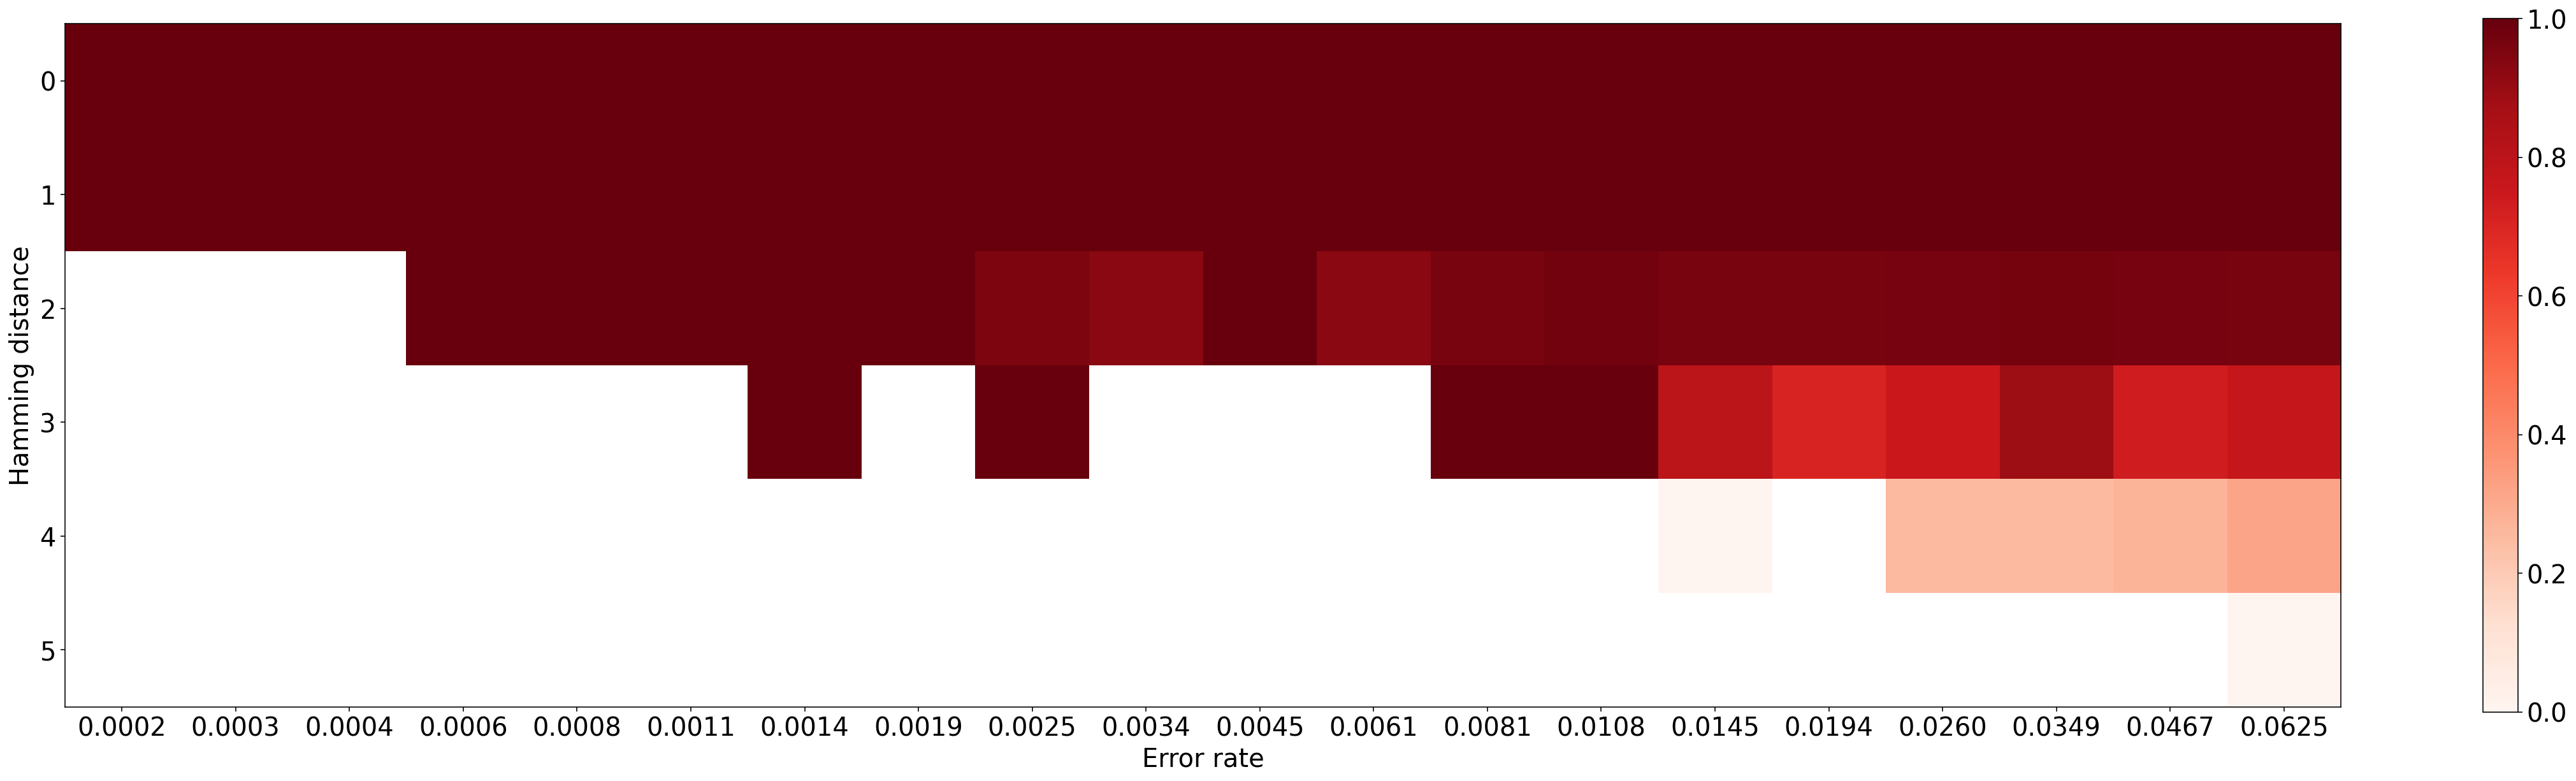

In [72]:
fig, ax = plt.subplots(figsize=(40,10))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, )
errors = [f"{i:,.4f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance"
})
fig.show()

In [120]:
from matplotlib import cm

In [121]:
cmap = cm.get_cmap("tab20")

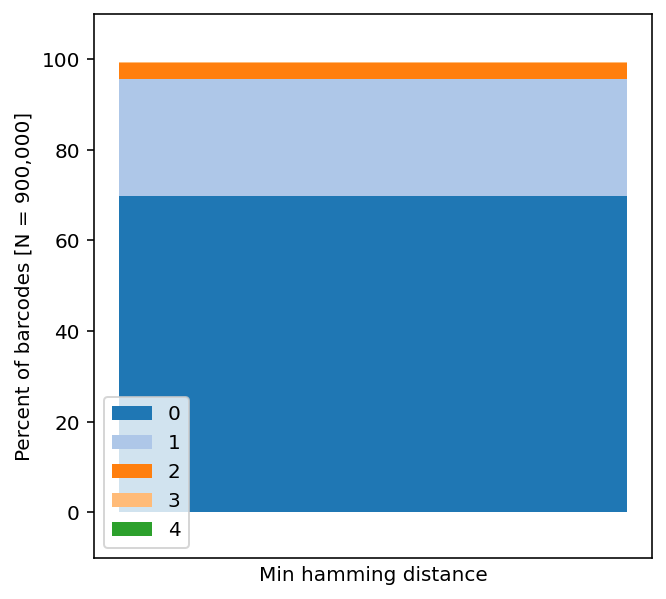

In [129]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.array([*data.keys()])
argsort = np.argsort(x)
xsum = x[argsort]

y = np.array([*data.values()])[argsort]
ysum = y/(N*n_bcs)*100

ax.bar(0,ysum[0], color=cmap(0), label=f"{xsum[0]}")
bottom = ysum[0]

for idx, height in enumerate(ysum[1:], 1):
  ax.bar(0, height, bottom=bottom, color=cmap(idx), label=f"{xsum[idx]}")
  bottom += height

ax.set(**{
    "xlabel": "Min hamming distance",
    "ylabel": f"Percent of barcodes [N = {N*n_bcs:,.0f}]",
    "ylim": (-10, 110),
    "xticklabels": [],
    "xticks": []
})
ax.legend()
fig.show()

In [134]:
def faster_elem_itvs(epts):
  d = defaultdict(set)
  prev_e = epts[0][0]
  prev_v = epts[0][1]

  c = set()
  c.add(prev_v)

  for i in range(1, len(epts)):
    curr_e = epts[i][0]
    curr_v = epts[i][1]

    if curr_e != prev_e:
      if len(c):
        d[(prev_e, curr_e)] = c.copy()

    if curr_v in c:
      c.remove(curr_v)
    else:
      c.add(curr_v)

    prev_e = curr_e
    prev_v = curr_v


  return d
  

In [151]:
epts = []

for (le, re), v in zip(assign[:,1:], np.arange(assign.shape[0])):
  epts.append((le, v))
  epts.append((re, v))

In [152]:
epts.sort(key=lambda x: x[0])

In [153]:
d = faster_elem_itvs(epts)

In [154]:
d.keys()

dict_keys([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)])

In [150]:
# for each elementary interval its the number of correct minus the number of ambiguous

defaultdict(set,
            {(2, 3): {False, True},
             (3, 4): {False, True},
             (4, 5): {False, True}})

In [166]:
for k,v in d.items():
  print(f"{k} ------------------")
  print("Assigned correct: ", correct[list(v)].sum())
  print("Assigned incorrect: ", (~correct[list(v)]).sum())
  print("Ambiguous: ", ambiguous[list(v)].sum())


(0, 1) ------------------
Assigned correct:  628184
Assigned incorrect:  4
Ambiguous:  0
(1, 2) ------------------
Assigned correct:  860060
Assigned incorrect:  4170
Ambiguous:  3616
(2, 3) ------------------
Assigned correct:  864499
Assigned incorrect:  1619
Ambiguous:  1220
(3, 4) ------------------
Assigned correct:  414889
Assigned incorrect:  129
Ambiguous:  72
(4, 5) ------------------
Assigned correct:  18843
Assigned incorrect:  1
Ambiguous:  0
(5, 6) ------------------
Assigned correct:  4
Assigned incorrect:  0
Ambiguous:  0


In [167]:
Counter(assign[:,])

array([[0, 0, 3],
       [0, 0, 3],
       [0, 1, 3],
       ...,
       [8, 0, 3],
       [8, 0, 3],
       [8, 0, 3]])